In [ ]:
pip install mysql.connector

In [ ]:
import pandas as pd 
import numpy as np 
import mysql.connector 
import seaborn as sns
import matplotlib.pyplot as plt
from mysql.connector import Error

In [ ]:
def create_db_connection():
    connection = None
    try:
        connection = mysql.connector.connect(
            host="bac.c5spguzjvsqr.ap-southeast-1.rds.amazonaws.com",
            user="admin",
            passwd= "^IW[qN8cs]znCPK2XE",
            database="bac"
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

In [ ]:
cn = create_db_connection()

MySQL Database connection successful


In [ ]:
# for when you need to apply changes to db (create/alter/insert, update, delete)
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query successful")
    except Error as err:
        print(f"Error: '{err}'")

In [ ]:
# for when you require a result from your query (read operations)
def read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return pd.DataFrame(result, columns= list(cursor.column_names))
    except Error as err:
        print(f"Error: '{err}'")

Loading in the `accounts_payable_payment`, `accounts_payable_vendor` and `accounts_payable_invoice` dataset.

In [ ]:
query = """
SELECT * FROM accounts_payable_payment_csv
"""
payments_df = read_query(cn, query)

In [ ]:
query = """
SELECT * FROM accounts_payable_vendor_csv
"""
vendor_df = read_query(cn, query)

In [ ]:
query = """
SELECT * FROM accounts_payable_invoice_csv
"""
invoice_df = read_query(cn, query)

# Flagging out vendors who have null or unlikely characteristics
This query will return a list of vendor_id which have bank_accounts which occur the most frequently. 

Assumption: supplier_receiving_bank_account follows some format, and it is not normal for bank_account numbers to be so vastly different from what is expected 

In [ ]:
query = """
select vendor_id, supplier_receiving_bank_account, count(supplier_receiving_bank_account)
from accounts_payable_vendor_csv
group by supplier_receiving_bank_account
order by count(supplier_receiving_bank_account) DESC
;
"""
unlikelyVendorBankAccounts = read_query(cn, query)

In [ ]:
unlikelyVendorBankAccounts['Vendor Name'] = list(zip(unlikelyVendorBankAccounts.vendor_id, unlikelyVendorBankAccounts.supplier_receiving_bank_account))
top10SuspiciousVendors = unlikelyVendorBankAccounts.head(10)[['Vendor Name', 'count(supplier_receiving_bank_account)']]
top10SuspiciousVendors

,Vendor Name,count(supplier_receiving_bank_account)
0,"(BJCA, 0)",13
1,"(9999, NULL)",4
2,"(C0006, 44444444)",3
3,"(G10084, 89040155300002272)",3
4,"(X0002, 5555555555)",3
5,"(AS-NBT, 222-562202-1)",2
6,"(F0054, 80020000004763899)",2
7,"(F0165, 108855325984)",2
8,"(G10109, 1778701207)",2
9,"(GHAC01, 3602001309219383838)",2


In [ ]:
topSuspiciousVendors = top10SuspiciousVendors.iloc[[0,1,2,4],]

Text(0.5, 0, 'Number of occurences')

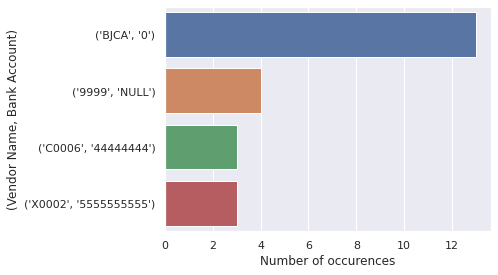

In [ ]:
ax = sns.barplot(y="Vendor Name", x="count(supplier_receiving_bank_account)", data=topSuspiciousVendors)
ax.set_ylabel('(Vendor Name, Bank Account)')
ax.set_xlabel('Number of occurences')

# Payments to discontinued/deactivated vendors

This query will return a list of payment `invoice_id` where payment has been made to vendors that are discontinued or deactivated, according to the vendor
 `purchasing_department` column.

__Assumption:__

All vendors listed as discontinued/deactivated have been discontinued/deactivated at the point of invoice and payment.

In [ ]:
query = """
select DISTINCT(invoice_id)
from accounts_payable_payment_csv
where vendor_id in (
    select vendor_id
    from accounts_payable_vendor_csv
    where purchasing_department LIKE '%discontinued%' OR purchasing_department LIKE '%deactivated%'
);
"""
invWithDiscontinued = read_query(cn, query)

In [ ]:
invWithDiscontinued

,invoice_id
0,AMDNV-5235410
1,APSWX-2012230001
2,APSWX-2102070010
3,APSWX-2010230003
4,APSWX-2011170003
...,...
74,APSWX-2101040006
75,APYF-2020100004
76,APYF-2020110008
77,APSWX-2011190002


There are 79 vendors (74 unique) that are supposedly 'discontinued' or 'deactivated' that still received payments. 

In [ ]:
discontinuedBankAcc = invWithDiscontinued.join(vendor_df,
                         how ='left',
                         )['supplier_receiving_bank_account'].unique()

In [ ]:
payments_df[payments_df['A'].isin(discontinuedBankAcc)]

array(['NULL', '222-562202-1', '0', '44444444', '3100022429022105280',
       '645757738618', '3602001309001188685', '2011021709220102863',
       '44050178050400000118', '44050178039800000188',
       '44001780398052504565', '310501040016471', '124905986010501',
       '40404500772000565', '31598503000819262', '443066058018000942227',
       '3602014609200123317', '31001565611050000562', 'H10791000395',
       '821053179608091001', '40402900000307017', 'H10797101492',
       '319456022543', '0763054135018401', '457263760190', '731557736758',
       '3602004519200168274', '669157738124', '441169087018010020904',
       '44050166720500000324', '630157736737', '44001781905053000863',
       '11004193813002', '129904948510802', '4042440143',
       '0302016509300006272', '448159229765', '627557745946',
       '741957940834', '1111111111', '44075301040005219',
       '7442610182600038343', '11007830563402', '3602830319100005493',
       '1204080009300376636', '448159247876', '4000091119100

In [255]:
query = """
select vendor_id, sum(total_amount) total_payment
from accounts_payable_payment_csv
where vendor_id in (
    select vendor_id
    from accounts_payable_vendor_csv
    where purchasing_department LIKE '%discontinued%' OR purchasing_department LIKE '%deactivated%'
)
group by vendor_id
order by total_payment desc;
"""
totalPaymentsDiscontinued = read_query(cn, query)

In [262]:
totalPaymentsDiscontinued['total_payment'] = totalPaymentsDiscontinued['total_payment'].astype(float)
totalPaymentsDiscontinued.describe()

,total_payment
count,7.000000e+01
mean,2.063599e+05
std,1.116544e+06
min,2.744000e+01
25%,5.376015e+03
50%,1.613799e+04
75%,4.396596e+04
max,9.252016e+06


In [272]:
totalPaymentsDiscontinued['total_payment'].sum()

14445195.099999996

Text(0.5, 0, 'Total Payment ($, millions)')

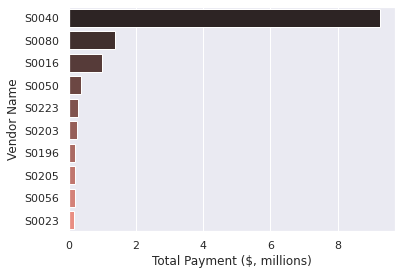

In [270]:
ax = sns.barplot(x=totalPaymentsDiscontinued['total_payment'].head(10)/1000000,y=totalPaymentsDiscontinued['vendor_id'].head(10), palette='dark:salmon')
ax.set_ylabel('Vendor Name')
ax.set_xlabel('Total Payment ($, millions)')

# Excess (fradulent) payments for invoices

Is there any payment that should not be made? This approach takes a vendor-centric point of view.

In [ ]:
payments_df.duplicated().describe()

count     5060
unique       2
top       True
freq      3745
dtype: object

In [ ]:
invoice_df.duplicated().describe()

count      6594
unique        2
top       False
freq       5780
dtype: object

From above, there are multiple rows where there is duplicate data. Here, we assume that this duplicate data is erroneously recorded in the system, so we get rid of it to see how much needs to be paid to vendors and how much is actually paid to vendors.

In [ ]:
# make copy prior to drop, then group by vendor id and sum the actual payments needed to vendors
payments_df_no_duplicates = payments_df.copy().drop_duplicates()
payments_df_no_duplicates_grouped = payments_df_no_duplicates.groupby(by='vendor_id').sum()
invoice_df_no_duplicates = invoice_df.copy().drop_duplicates()
invoice_df_no_duplicates_grouped = invoice_df_no_duplicates.groupby(by='vendor_id').sum()

In [ ]:
len(payments_df_no_duplicates_grouped)

267

In [ ]:
len(invoice_df_no_duplicates_grouped)

233

In [ ]:
invoice_df_no_duplicates_grouped.reset_index()['vendor_id'].isin(payments_df_no_duplicates_grouped.reset_index()['vendor_id']).describe()

count      233
unique       2
top       True
freq       232
Name: vendor_id, dtype: object

There is an Invoice with `vendor_id` not found in `Payment`: in other words we have not paid this vendor. This is acceptable and not the focus: rather we want to find vendors that we did not pay.

In [ ]:
invoice_df_no_duplicates_grouped.reset_index()[invoice_df_no_duplicates_grouped.reset_index()['vendor_id'].isin(payments_df_no_duplicates_grouped.reset_index()['vendor_id']) == False]

,vendor_id,amount_payable_untaxed,amount_payable_taxed,line_of_payable_list
187,S0167,5276.82,316.608765,5593.43


In [ ]:
# join invoice onto payments
paymentsWithInvoice2 = payments_df_no_duplicates_grouped.join(
    invoice_df_no_duplicates_grouped, 
    how='left',
    lsuffix='vendor_id',
    rsuffix='id')[['total_amount','line_of_payable_list']].reset_index()

paymentsWithInvoice2['total_amount'] = pd.to_numeric(paymentsWithInvoice2['total_amount'])

paymentsWithInvoice2.columns = ['vendor_id', 'total_amt_paid', 'total_amt_owed']

paymentsWithInvoice2

,vendor_id,total_amt_paid,total_amt_owed
0,F0002,3277.02,3247.70
1,F0003,30907.76,30643.33
2,F0004,655411.59,510535.88
3,F0009,9458.10,5052.45
4,F0010,21724.97,15822.42
...,...,...,...
262,W0020,41.26,NaN
263,W0023,3597.10,5132.69
264,W0024,3278.04,5744.19
265,W0025,3229.44,3119.71


__Assumption:__

- `Invoice` and `Payment` information (from `Accounts Payable Data`) is accurate as of the same date, so there is no missing data.

- Excessive payments to a vendor greater than the invoiced amount are considered as `overpaid`; excessive payments when there is no invoice are `fraud`.

In [ ]:
paymentsWithInvoice2['difference'] = paymentsWithInvoice2['total_amt_paid'] - paymentsWithInvoice2['total_amt_owed']

paymentsWithInvoice2['status'] = np.where(
    paymentsWithInvoice2['difference'] > 0, "overpaid", np.where( # overpaid, possibility of missing data
    paymentsWithInvoice2['difference'] == 0, "correct", np.where( # just nice balanced
    paymentsWithInvoice2['difference'] < 0, "underpaid", # underpaid is good bc we have free borrowed money (aka on credit terms)
    "fraud"))) # null case accounts for when there is no total_amt_owed associated with the vendor

paymentsWithInvoice2['difference'] = np.where(
    paymentsWithInvoice2['difference'].isna(), paymentsWithInvoice2['total_amt_paid'], paymentsWithInvoice2['difference']
)

paymentsWithInvoice2[['vendor_id','status']].groupby('status').count()

,vendor_id
status,
correct,31
fraud,35
overpaid,137
underpaid,64


In [ ]:
paymentsWithInvoice2.groupby('status').sum()['difference']

status
correct            0.00
fraud        2066166.93
overpaid     6539452.62
underpaid   -5288370.14
Name: difference, dtype: float64

In [ ]:
paymentsWithInvoice2

,vendor_id,total_amt_paid,total_amt_owed,difference,pct_diff,status,multiplier_diff
0,F0002,3277.02,3247.70,29.32,0.902793,overpaid,0.009028
1,F0003,30907.76,30643.33,264.43,0.862928,overpaid,0.008629
2,F0004,655411.59,510535.88,144875.71,28.377185,overpaid,0.283772
3,F0009,9458.10,5052.45,4405.65,87.198290,overpaid,0.871983
4,F0010,21724.97,15822.42,5902.55,37.304976,overpaid,0.373050
...,...,...,...,...,...,...,...
262,W0020,41.26,NaN,41.26,NaN,fraud,NaN
263,W0023,3597.10,5132.69,-1535.59,-29.917840,underpaid,-0.299178
264,W0024,3278.04,5744.19,-2466.15,-42.932946,underpaid,-0.429329
265,W0025,3229.44,3119.71,109.73,3.517314,overpaid,0.035173


Total $2,066,166.93 of payments to 35 vendors that have never sent an invoice.

Total $6,539,452.62 of excess payments to 137 vendors (based upon invoice totals).

Net Loss: $3,317,249.41 (excludes products bought on credit terms)

In [ ]:
paymentsWithInvoice2['multiplier_diff'] = paymentsWithInvoice2['difference'] / paymentsWithInvoice2['total_amt_owed']
paymentsWithInvoice2

,vendor_id,total_amt_paid,total_amt_owed,difference,pct_diff,status,multiplier_diff
0,F0002,3277.02,3247.70,29.32,0.902793,overpaid,0.009028
1,F0003,30907.76,30643.33,264.43,0.862928,overpaid,0.008629
2,F0004,655411.59,510535.88,144875.71,28.377185,overpaid,0.283772
3,F0009,9458.10,5052.45,4405.65,87.198290,overpaid,0.871983
4,F0010,21724.97,15822.42,5902.55,37.304976,overpaid,0.373050
...,...,...,...,...,...,...,...
262,W0020,41.26,NaN,41.26,NaN,fraud,NaN
263,W0023,3597.10,5132.69,-1535.59,-29.917840,underpaid,-0.299178
264,W0024,3278.04,5744.19,-2466.15,-42.932946,underpaid,-0.429329
265,W0025,3229.44,3119.71,109.73,3.517314,overpaid,0.035173


In [ ]:
top10overpaid_diff = paymentsWithInvoice2.sort_values('difference',ascending=False).head(10).reset_index(drop=True)
top10overpaid_pct = paymentsWithInvoice2.sort_values('pct_diff',ascending=False).head(10).reset_index(drop=True)

In [ ]:
top10overpaid_diff

,vendor_id,total_amt_paid,total_amt_owed,difference,pct_diff,status,multiplier_diff
0,NBSZ,1744018.13,513746.85,1230271.28,239.470331,overpaid,2.394703
1,F0086,2340342.05,1798617.06,541724.99,30.118973,overpaid,0.301190
2,S0016,500549.63,NaN,500549.63,NaN,fraud,NaN
3,S0033,384238.23,NaN,384238.23,NaN,fraud,NaN
4,F0040,3345642.50,2967113.70,378528.80,12.757475,overpaid,0.127575
5,F0070,672123.13,304157.44,367965.69,120.978691,overpaid,1.209787
6,F0072,576288.42,212961.41,363327.01,170.606971,overpaid,1.706070
7,F0018,331565.63,12479.44,319086.19,2556.895101,overpaid,25.568951
8,F0118,621759.63,341003.40,280756.23,82.332384,overpaid,0.823324
9,F0078,426052.22,183093.92,242958.30,132.695996,overpaid,1.326960


In [ ]:
top10overpaid_pct

,vendor_id,total_amt_paid,total_amt_owed,difference,pct_diff,status,multiplier_diff
0,F0018,331565.63,12479.44,319086.19,2556.895101,overpaid,25.568951
1,S0194,4336.90,250.92,4085.98,1628.399490,overpaid,16.283995
2,S0082,1189.27,191.04,998.23,522.524079,overpaid,5.225241
3,J0062,14109.60,2632.53,11477.07,435.971100,overpaid,4.359711
4,F0031,38243.55,7986.07,30257.48,378.878222,overpaid,3.788782
5,S0223,145301.87,35153.48,110148.39,313.335664,overpaid,3.133357
6,F0079,61437.65,17355.12,44082.53,254.003026,overpaid,2.540030
7,NBSZ,1744018.13,513746.85,1230271.28,239.470331,overpaid,2.394703
8,F0175,12894.44,4542.20,8352.24,183.880939,overpaid,1.838809
9,F0072,576288.42,212961.41,363327.01,170.606971,overpaid,1.706070


In [ ]:
sns.set(rc={'figure.figsize':(5.85,4.135)})

Text(0.5, 0, 'Number of times overpaid')

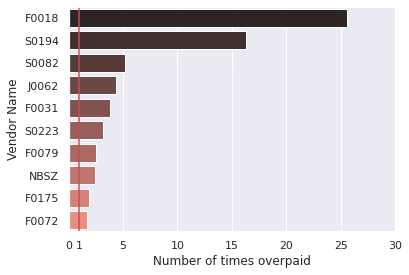

In [ ]:
ax = sns.barplot(x=top10overpaid_pct['multiplier_diff'],y=top10overpaid_pct['vendor_id'], palette='dark:salmon')
ax.axvline(1, color='r')
plt.xticks(list(plt.xticks()[0]) + [1])
ax.set_ylabel('Vendor Name')
ax.set_xlabel('Number of times overpaid')

Text(0.5, 0, 'Amount overpaid ($, thousands)')

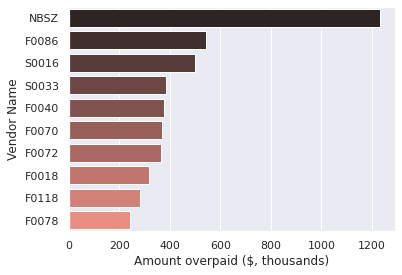

In [ ]:
ax = sns.barplot(x=top10overpaid_diff['difference']/1000,y=top10overpaid_diff['vendor_id'], palette='dark:salmon')
ax.set_ylabel('Vendor Name')
ax.set_xlabel('Amount overpaid ($, thousands)')

In [ ]:
top10overpaid_diff

,vendor_id,total_amt_paid,total_amt_owed,difference,pct_diff,status,multiplier_diff
144,NBSZ,1744018.13,513746.85,1230271.28,239.470331,overpaid,2.394703
49,F0086,2340342.05,1798617.06,541724.99,30.118973,overpaid,0.301190
150,S0016,500549.63,NaN,500549.63,NaN,fraud,NaN
155,S0033,384238.23,NaN,384238.23,NaN,fraud,NaN
20,F0040,3345642.50,2967113.70,378528.80,12.757475,overpaid,0.127575
36,F0070,672123.13,304157.44,367965.69,120.978691,overpaid,1.209787
38,F0072,576288.42,212961.41,363327.01,170.606971,overpaid,1.706070
8,F0018,331565.63,12479.44,319086.19,2556.895101,overpaid,25.568951
74,F0118,621759.63,341003.40,280756.23,82.332384,overpaid,0.823324
43,F0078,426052.22,183093.92,242958.30,132.695996,overpaid,1.326960


Text(0.5, 0, 'Possible Loss ($)')

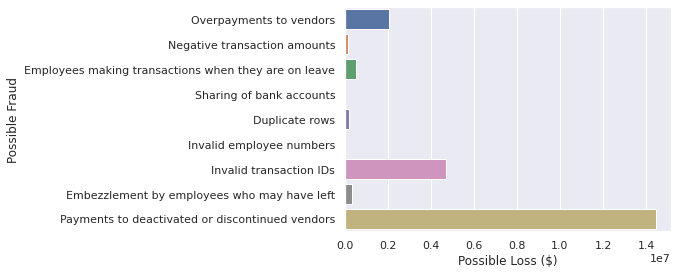

In [280]:
dollarLoss = [2066166.93, 158065.98, 530097.97, 13756.36, 205786.48, 1978.28, 4715186.84, 358596.62, 14445195.10]
lossNames = ["Overpayments to vendors", "Negative transaction amounts", "Employees making transactions when they are on leave", "Sharing of bank accounts", "Duplicate rows", "Invalid employee numbers", "Invalid transaction IDs", "Embezzlement by employees who may have left", "Payments to deactivated or discontinued vendors"]
ax = sns.barplot(x=dollarLoss, y=lossNames)
ax.set_ylabel('Possible Fraud')
ax.set_xlabel('Possible Loss ($)')